#  Basic Setup 



> Importing Libraries

In [260]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from matplotlib import pyplot as plt
import json
import re
import nltk

!pip install contractions
import contractions
!pip install emot
from emot.emo_unicode import EMOTICONS_EMO
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


> Downloads (For Google Collab)

In [261]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

> Reading Datasets (Train & Test)

In [316]:
trainData = pd.read_csv('train.csv')
testData  = pd.read_csv('test.csv')

# Pre-Processing

> Checking For Null Values

In [317]:
trainData.isna().sum()

id                 0
text               0
harsh              0
extremely_harsh    0
vulgar             0
threatening        0
disrespect         0
targeted_hate      0
dtype: int64

In [318]:
(trainData == "?").sum()

id                 0
text               0
harsh              0
extremely_harsh    0
vulgar             0
threatening        0
disrespect         0
targeted_hate      0
dtype: int64

- No Null Values were found.

> Checking For Duplicates

In [319]:
trainData.drop(['id'], axis=1).duplicated().sum()

0

- No Duplicates Were Found

> Exploring Data

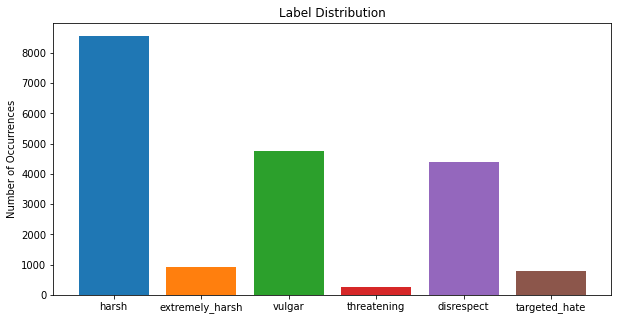

In [320]:
plt.figure(figsize=(10,5))
for column in trainData.columns.values:
  if column == "id" or column == "text":
    continue
  plt.bar(column,trainData[column].sum())

plt.title("Label Distribution")
plt.ylabel("Number of Occurrences")
plt.show()

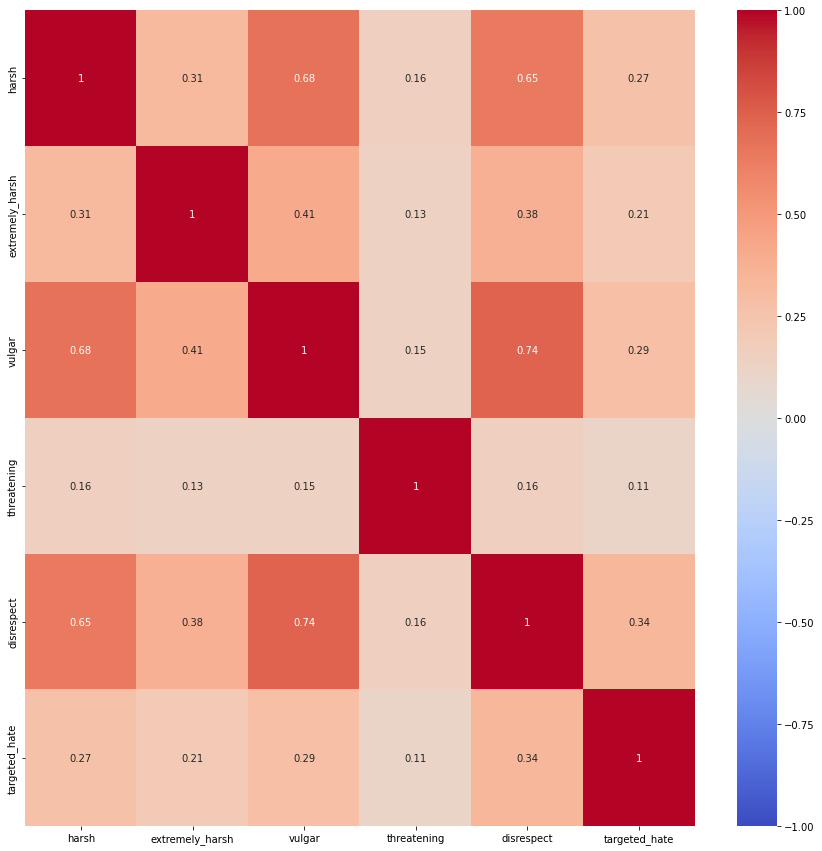

In [322]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(trainData[["harsh","extremely_harsh","vulgar","threatening","disrespect","targeted_hate"]].corr(), vmin=-1, cmap="coolwarm", annot=True)

> Expanding Contractions

In [267]:
def ExpandContractions(dataSet):
  newColumn = []
  for text in dataSet["text"]:
      newWords=[]
      for word in text.split():
          try:
              newWords.append(contractions.fix(word)+" ")
          except:
              continue      
      newColumn.append("".join(newWords))
  
  #Replacing Text With Expanded Text
  dataSet["text"] = newColumn

> Expanding Emoticons

In [268]:
def ExpandEmoticons(dataSet):
  #Expanding Contractions in The Dataset
  newColumn = []
  for text in dataSet["text"]:
      for emotes in EMOTICONS_EMO:
          text = text.replace(emotes, " "+EMOTICONS_EMO[emotes].replace(" ","_"))
      newColumn.append(text)
  
  #Replacing Text With Expanded Text
  dataSet["text"] = newColumn

> Removing Speical Characters & Numbers 

In [269]:
def RemoveNonLanguageContent(dataSet):
  #Removing Special Characters & Digits From All Comments
  newColumn = []
  for text in dataSet["text"]:
      newColumn.append(re.sub(r'\s+', ' ',re.sub('[^A-Za-z ]+','',text)))

  #Replacing Old Text Column With New Text Column
  dataSet["text"] = newColumn

> Removing Stop Words

In [270]:
def RemoveStopWords(dataSet):
  #Getting A List of Stop Words
  stopWords = stopwords.words('english')

  #Eliminating Stop Words From Every Comment
  newColumn = []
  for text in dataSet["text"]:
    new_Sentence=[]
    for word in text.split():
      if(word.lower() not in stopWords):
        if(word[:3]=="www" and word[:4]=="http"):
          continue
        else:
          new_Sentence.append(word+" ")
    newColumn.append("".join(new_Sentence))

  #Replacing Old Text Column With New Text Column
  dataSet["text"]=newColumn

> Lemmetization

In [271]:
def get_pos_tagger(nltk_tag):
    PosTag = {"J" : wordnet.ADJ,"V" : wordnet.VERB,"R" : wordnet.ADV,"N" : wordnet.NOUN}
    return PosTag.get(nltk_tag[0],None)

def Lemmetization(dataSet):
  lemmatizer = WordNetLemmatizer()
  newColumn=[]
  for text in dataSet["text"]:
      lemmatized_sentence = []
      pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))
      word_tagged = list(map(lambda x: (x[0], get_pos_tagger(x[1])), pos_tagged))
      for word, tag in word_tagged:
          if tag is None:
              lemmatized_sentence.append(lemmatizer.lemmatize(word))
          else:
              lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
      newColumn.append(" ".join(lemmatized_sentence))
  #Replacing Old Text Column With New Text Column
  dataSet["text"]=newColumn

> Pre-Processing (All the Above Steps)

In [272]:
def PreProcess(dataSet):
  ExpandContractions(dataSet)
  ExpandEmoticons(dataSet)
  RemoveNonLanguageContent(dataSet)
  RemoveStopWords(dataSet)
  Lemmetization(dataSet)

In [273]:
trainData.head()

In [274]:
PreProcess(trainData)
PreProcess(testData)

(Commet Above Code and Uncomment Below Cell To Skip Pre-Processing)

In [275]:
# trainData = pd.read_csv('preprocess_train.csv')
# testData  = pd.read_csv('preprocess_test.csv')

In [276]:
# trainData["text"].fillna(' ',inplace =True)
# testData["text"].fillna(' ',inplace=True)

# Feature Extraction

> Word Featrues : TF-IDF

In [277]:
def VectorizeWords(trainData,testData):
  #Setting HyperParameters
  wordVectorizer = TfidfVectorizer(
      analyzer = "word",
      lowercase = True,
      strip_accents = "unicode",
      ngram_range = (1,2),
      min_df = 2,
      max_df = 0.5,
      sublinear_tf = True,
  )

  wordVectorizer.fit(trainData["text"].tolist() + testData["text"].tolist()) 
  trainFeatures = wordVectorizer.transform(trainData["text"])
  testFeatures  = wordVectorizer.transform(testData["text"])

  return trainFeatures,testFeatures

In [278]:
train_Word_Features,test_Word_Features = VectorizeWords(trainData,testData)

In [279]:
def VectorizeCharacters(trainData,testData):
    character_Vectorizer= TfidfVectorizer(
        analyzer = "char",
        lowercase = True,
        strip_accents = "unicode", 
        ngram_range = (2, 6),  
        min_df = 2, 
        max_df = 0.5,
        sublinear_tf = True
    )

    character_Vectorizer.fit(trainData["text"].tolist() + testData["text"].tolist())
    trainFeatures = character_Vectorizer.transform(trainData["text"])
    testFeatures  = character_Vectorizer.transform(testData["text"])

    return trainFeatures, testFeatures

In [280]:
train_Character_Features, test_Character_Features = VectorizeCharacters(trainData,testData)

In [281]:
train_features = hstack([train_Word_Features, train_Character_Features])
test_features  = hstack([test_Word_Features, test_Character_Features])

# Model Training & Testing 

> Train-Test Split

In [282]:
labels = ["harsh","extremely_harsh","vulgar","threatening","disrespect","targeted_hate"]
trainX,testX,trainY,testY = train_test_split(train_features,trainData[labels],train_size=0.75)

> Model Testing 

In [283]:
def TestModel(modelList,testX,testY,labels):
  testP = pd.DataFrame()
  for i in range(len(modelList)):
    yTrain = testY[labels[i]]
    yPred  = modelList[i].predict(testX)
    testP[labels[i]] = yPred

  print("F1 Scores [1]: ",f1_score(testY.values,testP,average=None))
  print("F1 Scores [0]: ",f1_score(1-testY.values,1-testP,average=None))
  print("Accuracy  : ",accuracy_score(testY.values,testP))

> Model Outputs

In [284]:
def PredictOutput(modelList,testIds,testFeatures,labels):
  output = pd.DataFrame()
  output.insert(0,"id",testIds)

  for i in range(len(modelList)):
    yPred  = modelList[i].predict_proba(testFeatures)[:,1]
    output.insert(i+1,labels[i],yPred)
  
  output.to_csv("output.csv",index=False)

> Logistic Regression

In [285]:
import pickle
def LogisticRegressionModel(trainX,trainY,labels):
  #Multi Label : Different Models For Different Labels
  modelList = []
  for label in labels:
    lrModel = LogisticRegression(solver='liblinear',class_weight = 'balanced')
    lrModel.fit(trainX,trainY[label])
    pickle.dump(lrModel,open("LogisticRegressionLib_"+label+".pckl", 'wb'))
    modelList.append(lrModel)

  return modelList

In [286]:
# lrModels = LogisticRegressionModel(train_features,trainData[labels],labels)
# TestModel(lrModels,testX,testY,labels)
# PredictOutput(lrModels,testData["id"],test_features,labels)

F1 Scores [1]:  [0.85211996 0.54166667 0.88822653 0.56809339 0.80444444 0.56275862]
F1 Scores [0]:  [0.98205546 0.99147365 0.99285646 0.99750129 0.98742258 0.99278808]
Accuracy  :  0.9231871083258729


>Naive Bayes

In [309]:
from sklearn import naive_bayes
def Naive_Bayes(trainX,trainY,labels):
  modelList=[]
  for label in labels:
    Naive_Model = naive_bayes.MultinomialNB()
    Naive_Model.fit(trainX, trainY[label])
    modelList.append(Naive_Model)
  return modelList

In [310]:
Naive_Model=Naive_Bayes(train_features, trainData[labels],labels)
TestModel(Naive_Model,testX,testY,labels)
PredictOutput(Naive_Model,testData["id"],test_features,labels)

F1 Scores [1]:  [0.75263158 0.45833333 0.7690387  0.06976744 0.70953437 0.38522427]
F1 Scores [0]:  [0.97446914 0.99352238 0.98687229 0.99820604 0.98456099 0.99474053]
Accuracy  :  0.9085049239033124


>Support Vector Machine

In [289]:
from sklearn import svm
def SVM(trainX,trainY,labels):
  modelList=[]
  for label in labels:
    SVM_Model = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM_Model.fit(trainX, trainY[label])
    modelList.append(SVM_Model)
  return modelList

> Chain Classifiers

In [290]:
def ChainClassifier(trainX,trainY,model):
  classifier = ClassifierChain(model, order='random')
  classifier.fit(trainX,trainY)
  return classifier

In [291]:
def ChainClassifierPredict(chain,testIds,testFeatures,labels):
  output = pd.DataFrame()
  output.insert(0,"id",testIds)

  yPred = chain.predict_proba(testFeatures)

  for i in range(len(labels)):
    output.insert(i+1,labels[i],yPred[:,i])
  
  output.to_csv("output.csv",index=False)

- Logistic Regression Chain

In [311]:
classifier = ChainClassifier(train_features,trainData[labels],LogisticRegression())
ChainClassifierPredict(classifier,testData["id"],test_features,labels)

- Naive Bayes Chain

In [313]:
NBChain = ChainClassifier(train_features,trainData[labels],naive_bayes.MultinomialNB())
ChainClassifierPredict(NBChain,testData["id"],test_features,labels)

> Random Forest

In [294]:
from sklearn.ensemble import RandomForestClassifier
import pickle
def Random_Forest(trainX,trainY,labels):
  modelList=[]
  for label in labels:
    RF_Model = RandomForestClassifier(max_features = 5000, max_depth = 100, min_samples_split = 10, criterion = 'gini', n_estimators = 120, max_leaf_nodes = None)
    RF_Model.fit(trainX, trainY[label])
    pickle.dump(RF_Model, open("RandomForest_"+label+".pckl", 'wb'))
    modelList.append(RF_Model)
  return modelList

In [295]:
Rf_Model=Random_Forest(train_features, trainData[labels[5:]],labels[5:])

- Reading Models

In [296]:
def ReadModels(modelName,labels):
  modelList = []
  for label in labels:
    modelList.append(pickle.load(open(modelName+"_"+label+".pckl", 'rb')))
  return modelList

In [297]:
rfModels = ReadModels("RandomForest",labels)
TestModel(rfModels,testX,testY,labels)
PredictOutput(rfModels,testData["id"],test_features,labels)

> Ridge Classifier

In [298]:
from sklearn.linear_model import RidgeClassifier
import pickle

def RidgeClassifierModel(trainX,trainY,labels):
  modelList = []
  for label in labels:
    rcModel = RidgeClassifier(solver = 'sag',alpha = 27)
    rcModel.fit(trainX,trainY[label])
    pickle.dump(rcModel, open("RidgeClassifierMax_"+label+".pckl", 'wb'))
    modelList.append(rcModel)

  return modelList

In [315]:
RidgeClassifierModel(train_features,trainData[labels],labels)
rcModels =  ReadModels("RidgeClassifierMax",labels)
TestModel(rcModels,testX,testY,labels)

In [300]:
#There is no predict_proba for ridge classifier
def GiveOutput(modelList,testIds,testFeatures,labels):
  output = pd.DataFrame()
  output.insert(0,"id",testIds)

  for i in range(len(modelList)):
    yPred  = modelList[i].predict(testFeatures)
    output.insert(i+1,labels[i],yPred)
  
  output.to_csv("output.csv",index=False)

In [301]:
rcModels = ReadModels("RidgeClassifierMax",labels)
GiveOutput(rcModels,testData["id"],test_features,labels)

> Logistic Regression (Cross Validation)

In [302]:
from sklearn.linear_model import LogisticRegressionCV
def LogisticRegressioncv(trainX,trainY,labels):
  #Multi Label : Different Models For Different Labels
  modelList = []
  for label in labels:
    lrCVModel = LogisticRegressionCV(solver = 'sag', n_jobs = -1)
    lrCVModel.fit(trainX,trainY[label])
    pickle.dump(lrCVModel, open("LogisticRegressionCVMax_"+label+".pckl", 'wb'))
    modelList.append(lrCVModel)
  return modelList

In [303]:
LogisticRegressioncv(train_features,trainData[labels],labels)
lrCVModels = ReadModels("LogisticRegressionCVMax",labels)
TestModel(lrCVModels,testX,testY,labels)
PredictOutput(lrCVModels,testData["id"],test_features,labels)

> Logistic Regression (Grid Search CV)

In [304]:
from sklearn.model_selection import GridSearchCV
def FindBestParameters(trainX,trainY,labels,model,parameters):
  #Best Estimator Model
  modelList = []
  for label in labels:
    #Setting Grid Search Parameters & Estimator
    modelGrid = GridSearchCV(model,parameters)
    modelGrid.fit(trainX,trainY[label])
    
    #Storing & Displaying Best Estimator
    pickle.dump(modelGrid.best_estimator_,open("LogisticRegressionGrid_"+label+".pckl", 'wb'))
    modelList.append(modelGrid.best_estimator_)
    print("Label : " + label + "; Parameters : ",end = "")
    print(modelGrid.best_params_)
  
  return modelList

In [305]:
FindBestParameters(train_features,trainData[labels[1:]],labels[1:],LogisticRegression(class_weight="balanced"),{"C":[0.2*x for x in range(1,6)]})

In [306]:
lrGridModels = ReadModels("LogisticRegressionGrid",labels)
TestModel(lrGridModels,testX,testY,labels)
PredictOutput(lrGridModels,testData["id"],test_features,labels)

> Ridge Regression

In [307]:
from sklearn.linear_model import Ridge

def RidgeModel(trainX,trainY,labels):
  modelList = []
  for label in labels:
    rcModel = Ridge(alpha=14,solver='sag', max_iter=1000)
    rcModel.fit(trainX,trainY[label])
    pickle.dump(rcModel, open("RidgeMax_"+label+".pckl", 'wb'))
    modelList.append(rcModel)

  return modelList

In [308]:
RidgeModel(train_features,trainData[labels],labels)
rciModels = ReadModels("RidgeMax",labels)
GiveOutput(rciModels,testData["id"],test_features,labels)